In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split

# Direct classes included for easyness
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

In [2]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split, random_state=42)

### Enter your tag as unique id for saving

In [3]:
tag = str("quantumAutoencoder-18032023")

In [4]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
x_qubits = 3
compression = 3

dev = qml.device("default.qubit", wires=n_qubits)

Params in the quantum layer to train: 45
0: ──RY(0.12)──RY(0.14)─╭●──────────────────╭●──────────────────╭●─────────RY(0.27)──────────
1: ──RY(0.32)──RY(0.75)─╰RY(0.52)─╭●────────╰RY(0.15)─╭●────────╰RY(0.22)─╭●─────────RY(0.85)
2: ──RY(0.45)──RY(0.92)───────────╰RY(0.90)─╭●────────╰RY(0.06)─╭●────────╰RY(0.49)─╭●───────
3: ──RY(1.00)──RY(0.18)─────────────────────╰RY(0.86)─╭●────────╰RY(0.71)─╭●────────╰RY(0.33)
4: ──RY(0.12)──RY(0.69)───────────────────────────────╰RY(0.72)───────────╰RY(0.88)──────────

──────────────────────┤     
──────────────────────┤  <Z>
───RY(0.71)───────────┤  <Z>
──╭●─────────RY(0.42)─┤  <Z>
──╰RY(0.81)──RY(0.17)─┤     


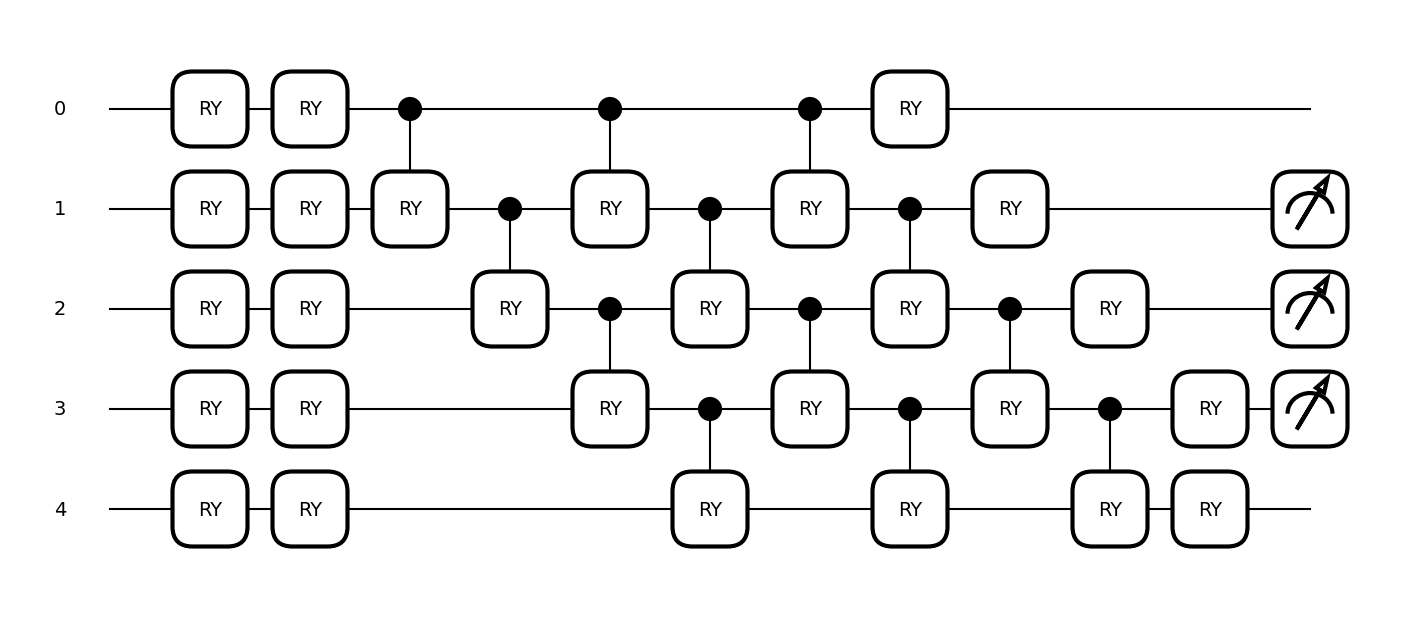

In [5]:
# Encoder
ENC_weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1),
                 "weight5": (n_qubits)}
nE_qcParams = n_qubits*3+2*3*n_qubits
print(f"Params in the quantum layer to train: {nE_qcParams}")



@qml.qnode(dev)
def encoder(inputs, weight1, weight2, weight3, weight4, weight5):
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=inputs, pattern="single")
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight4, pattern="chain")
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    return [qml.expval(qml.PauliZ(wires=i+1)) for i in range(compression)]

qEncoder = qml.qnn.KerasLayer(encoder, ENC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(encoder)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits)))
fig1, ax = qml.draw_mpl(encoder)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits))
plt.show()
fig1.savefig("archive/Encoder-"+tag+".png")
fig1.savefig("archive/Encoder-"+tag+".pdf")

Params in the quantum layer to train: 45
0: ──RY(0.34)───────────╭●──────────────────╭●──────────────────╭●─────────RY(0.01)──────────
1: ──RY(0.12)──RY(0.82)─╰RY(0.94)─╭●────────╰RY(0.96)─╭●────────╰RY(0.02)─╭●─────────RY(0.13)
2: ──RY(0.32)──RY(0.10)───────────╰RY(0.95)─╭●────────╰RY(0.63)─╭●────────╰RY(0.02)─╭●───────
3: ──RY(0.45)──RY(0.76)─────────────────────╰RY(0.34)─╭●────────╰RY(0.99)─╭●────────╰RY(0.40)
4: ──RY(0.49)─────────────────────────────────────────╰RY(0.97)───────────╰RY(0.57)──────────

──────────────────────┤  <Z>
──────────────────────┤  <Z>
───RY(0.06)───────────┤  <Z>
──╭●─────────RY(0.30)─┤  <Z>
──╰RY(0.73)──RY(0.79)─┤  <Z>


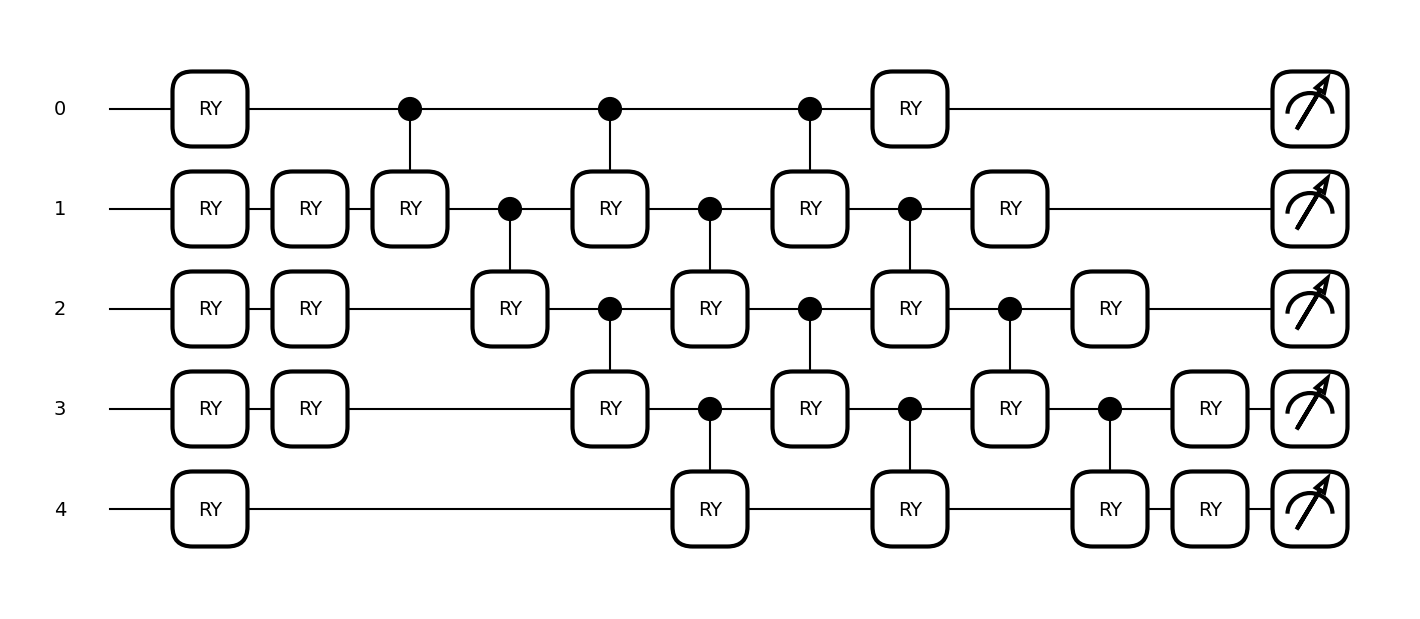

In [6]:
# Decoder
DEC_weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1),
                 "weight5": (n_qubits)}
nD_qcParams = n_qubits*3+2*3*n_qubits
print(f"Params in the quantum layer to train: {nD_qcParams}")



@qml.qnode(dev)
def decoder(inputs, weight1, weight2, weight3, weight4, weight5):
    qml.broadcast(qml.RY, wires=[1,2,3], parameters=inputs, pattern="single")
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight4, pattern="chain")
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qDecoder = qml.qnn.KerasLayer(decoder, DEC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(decoder)(x_train[0,:3],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits)))
fig2, ax = qml.draw_mpl(decoder)(x_train[0,:3],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits))
plt.show()
fig2.savefig("archive/Decoder-"+tag+".png")
fig2.savefig("archive/Decoder-"+tag+".pdf")

In [7]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()

inputLayer = Input(shape=(x_train.shape[1],))
encoded = qEncoder(inputLayer)
decoded = qDecoder(encoded)
autoencoder = Model(inputLayer, decoded)
print(f"Params in all quantum layers to train: {nD_qcParams+nE_qcParams}")
autoencoder.summary()
plot_model(autoencoder,"archive/model"+tag+".png")

Params in all quantum layers to train: 90
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 0 (unused)
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 0 (unused)
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
# Encoder
encoder = Model(inputLayer, encoded)
# Decoder
encoded_input = Input(shape=(compression,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [9]:
# Test Learning Rate Scheduler Parameters
print(.1* tf.math.exp(-2.3))

tf.Tensor(0.010025885, shape=(), dtype=float32)


In [10]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

autoencoder.compile(optimizer = optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

autoencoder_history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

Epoch 1/50
31/31 [==============================] - 193s 6s/step - loss: 0.0438 - mean_absolute_error: 0.1565 - val_loss: 0.0292 - val_mean_absolute_error: 0.1205 - lr: 0.0500
Epoch 2/50
31/31 [==============================] - 195s 6s/step - loss: 0.0272 - mean_absolute_error: 0.1250 - val_loss: 0.0262 - val_mean_absolute_error: 0.1323 - lr: 0.0500
Epoch 3/50
31/31 [==============================] - 196s 6s/step - loss: 0.0259 - mean_absolute_error: 0.1209 - val_loss: 0.0274 - val_mean_absolute_error: 0.1197 - lr: 0.0500
Epoch 4/50
31/31 [==============================] - 197s 6s/step - loss: 0.0260 - mean_absolute_error: 0.1219 - val_loss: 0.0272 - val_mean_absolute_error: 0.1079 - lr: 0.0500
Epoch 5/50
31/31 [==============================] - 198s 6s/step - loss: 0.0259 - mean_absolute_error: 0.1215 - val_loss: 0.0402 - val_mean_absolute_error: 0.1655 - lr: 0.0500
Epoch 6/50
31/31 [==============================] - 197s 6s/step - loss: 0.0256 - mean_absolute_error: 0.1215 - val_loss

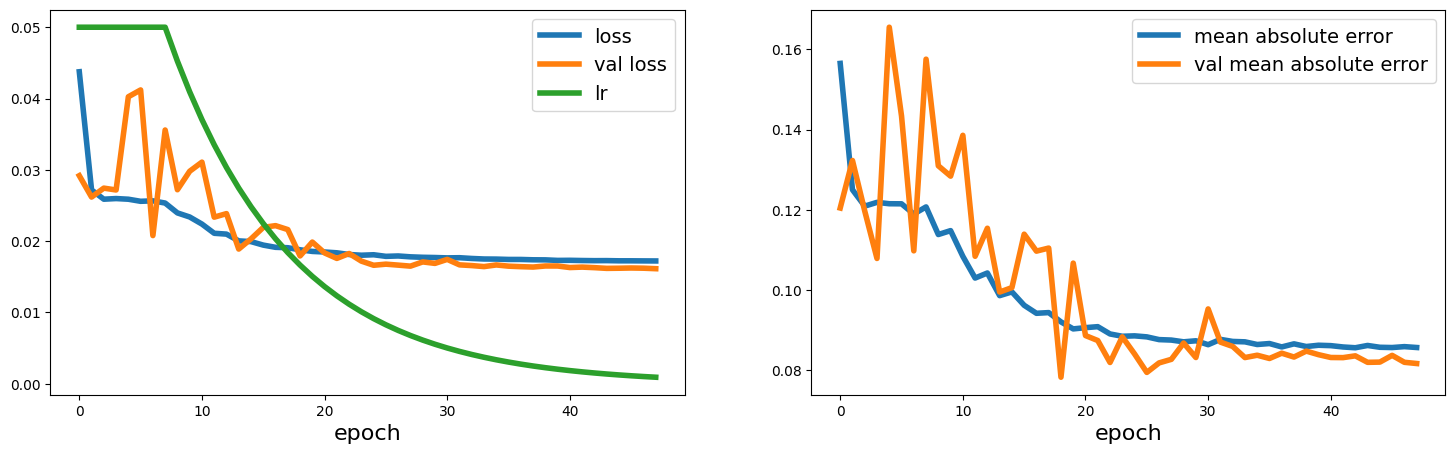

In [11]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)
plt.savefig("archive/history-"+tag+".png")

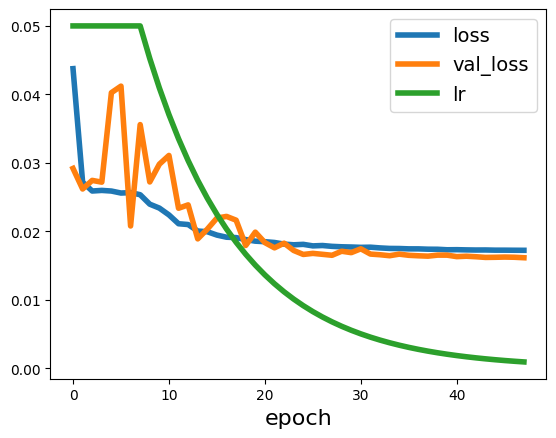

In [12]:
fig = plt.figure()
plt.plot(autoencoder_history.history['loss'], lw=4, label='loss')
plt.plot(autoencoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(autoencoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [ ]:
encoded_train = encoder.predict(x_train)
np.save("ENCdata_"+tag+".npy", encoded_train)

In [13]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')

16/16 [==============================] - 26s 2s/step
Data: [0.07070707 0.42792793 0.         0.         0.07262615] to be: [0.10632951 0.58551909 0.52530123] and rebuilded it to: [0.13305771 0.41814021 0.05163536 0.07739258 0.25409663]


In [14]:
encoder.save("archive/encoderModel-"+tag+".h5")
encoder.save_weights("archive/encoderWeights-"+tag+".h5")
autoencoder.save("archive/completeModel-"+tag+".h5")
autoencoder.save_weights("archive/autoencoderWeights-"+tag+".h5")
config = encoder.get_config()
np.save("archive/encoderConfig-"+tag+".npy", config)
config = autoencoder.get_config()
np.save("archive/completeConfig-"+tag+".npy", config)

In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 22        
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 22        
                                                                 
Total params: 44
Trainable params: 44
Non-trainable params: 0
_________________________________________________________________
